# AUS dataprep

This notebook transforms the data as given by Ausgrid in a format that we can use with our models, and adds (approximate) latitude and longitude information for all the zipcodes.

In [14]:
import pandas as pd
import json
from matplotlib import pyplot as plt

In [3]:
aus_2012 = pd.read_csv('../data/australia/2011-2012 Solar home electricity data v2.csv')
aus_2013 = pd.read_csv('../data/australia/2012-2013 Solar home electricity data v2.csv')

In [4]:
def aus_clean(aus_raw):
    """
    Transform the Ausgrid data in a pandas dataframe which can be used in our code
    :param aus_raw: the data in the original format, as presented in a pandas DataFrame by simply doing pd.read_csv(file) 
    :return: a new pandas DataFrame
    """
    # Only keep GG for solar generation
    # Filter the DataFrame to keep only rows with 'GG' in the 'Consumption Category' column
    aus_df = aus_raw[aus_raw['Consumption Category'] == 'GG']
    
    # Extract the time columns
    time_columns = aus_df.columns[5:-1]
    
    # Melt the DataFrame to combine the half-hour columns into rows under the "Values" column
    aus_melted = pd.melt(aus_df, id_vars=['date', 'Customer', 'Postcode', 'Generator Capacity'], value_vars=time_columns, var_name='Time', value_name='Values')
    
    # Correctly set the date in the right format, as our index
    aus_melted['date'] = aus_melted['date'] + ' ' + aus_melted['Time'] + ':00'
    aus_melted.drop(columns=['Time'], inplace=True)
    aus_melted.set_index('date', inplace=True)
    aus_melted.index = pd.to_datetime(aus_melted.index, format="%d/%m/%Y %H:%M:%S")
    
    # Sort the DataFrame by the datetime index and the customer
    aus_melted.sort_values(by=['Customer', 'date'], inplace=True)
    
    return aus_melted

In [5]:
# Get the 2012 data
aus_2012_clean = aus_clean(aus_2012)
aus_2012_clean

,Customer,Postcode,Generator Capacity,Values
date,,,,
2011-07-01 00:00:00,1,2076,3.78,0.0
2011-07-01 00:30:00,1,2076,3.78,0.0
2011-07-01 01:00:00,1,2076,3.78,0.0
2011-07-01 01:30:00,1,2076,3.78,0.0
2011-07-01 02:00:00,1,2076,3.78,0.0
...,...,...,...,...
2012-06-30 21:30:00,300,2086,3.36,0.0
2012-06-30 22:00:00,300,2086,3.36,0.0
2012-06-30 22:30:00,300,2086,3.36,0.0


In [6]:
# Get the 2013 data
aus_2013_clean = aus_clean(aus_2013)
aus_2013_clean

,Customer,Postcode,Generator Capacity,Values
date,,,,
2012-07-01 00:00:00,1.0,2076.0,3.78,0.0
2012-07-01 00:30:00,1.0,2076.0,3.78,0.0
2012-07-01 01:00:00,1.0,2076.0,3.78,0.0
2012-07-01 01:30:00,1.0,2076.0,3.78,0.0
2012-07-01 02:00:00,1.0,2076.0,3.78,0.0
...,...,...,...,...
2013-06-30 21:30:00,300.0,2086.0,3.36,0.0
2013-06-30 22:00:00,300.0,2086.0,3.36,0.0
2013-06-30 22:30:00,300.0,2086.0,3.36,0.0


In [28]:
# Concatenate the two dataframes and sort the values
aus_combined = pd.concat([aus_2012_clean,aus_2013_clean], axis=0)
aus_combined.sort_values(by=['Customer', 'date'], inplace=True)

aus_combined

,Customer,Postcode,Generator Capacity,Values
date,,,,
2011-07-01 00:00:00,1.0,2076.0,3.78,0.0
2011-07-01 00:30:00,1.0,2076.0,3.78,0.0
2011-07-01 01:00:00,1.0,2076.0,3.78,0.0
2011-07-01 01:30:00,1.0,2076.0,3.78,0.0
2011-07-01 02:00:00,1.0,2076.0,3.78,0.0
...,...,...,...,...
2013-06-30 21:30:00,300.0,2086.0,3.36,0.0
2013-06-30 22:00:00,300.0,2086.0,3.36,0.0
2013-06-30 22:30:00,300.0,2086.0,3.36,0.0


In [8]:
# Get unique customer IDs
customer_ids = aus_combined['Customer'].unique()

# Find missing dates for each customer
missing_dates = {}
for customer_id in customer_ids:
    customer_data = aus_combined[aus_combined['Customer'] == customer_id]
    date_range = pd.date_range(start='2011-07-01', end='2013-07-01', freq='30T')
    date_range = date_range[:-1]
    missing_dates[customer_id] = date_range[~date_range.isin(customer_data.index)]
    
missing_dates

{1.0: DatetimeIndex([], dtype='datetime64[ns]', freq='30T'),
 2.0: DatetimeIndex(['2012-10-12 00:00:00', '2012-10-12 00:30:00',
                '2012-10-12 01:00:00', '2012-10-12 01:30:00',
                '2012-10-12 02:00:00', '2012-10-12 02:30:00',
                '2012-10-12 03:00:00', '2012-10-12 03:30:00',
                '2012-10-12 04:00:00', '2012-10-12 04:30:00',
                ...
                '2012-12-31 19:00:00', '2012-12-31 19:30:00',
                '2012-12-31 20:00:00', '2012-12-31 20:30:00',
                '2012-12-31 21:00:00', '2012-12-31 21:30:00',
                '2012-12-31 22:00:00', '2012-12-31 22:30:00',
                '2012-12-31 23:00:00', '2012-12-31 23:30:00'],
               dtype='datetime64[ns]', length=3888, freq='30T'),
 3.0: DatetimeIndex([], dtype='datetime64[ns]', freq='30T'),
 4.0: DatetimeIndex([], dtype='datetime64[ns]', freq='30T'),
 5.0: DatetimeIndex([], dtype='datetime64[ns]', freq='30T'),
 6.0: DatetimeIndex([], dtype='datetime64[ns]

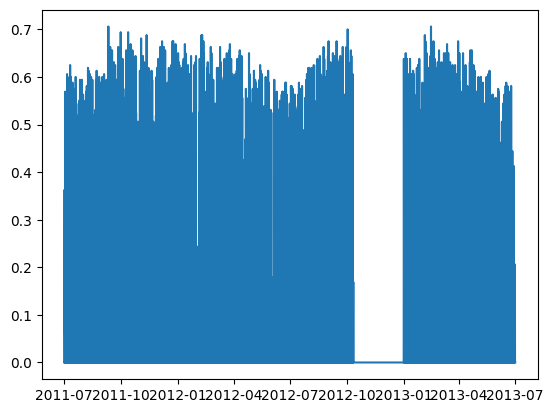

In [9]:
# Plot the missing dates
plt.plot(aus_combined[aus_combined['Customer'] == 2]['Values'])

In [10]:
# Remove customer 2 from the final DataFrame
aus_combined = aus_combined[aus_combined['Customer'] != 2.0]

In [20]:
# Load our lat/long data for the zipcodes
with open("../data/australia/location_dict.json", 'r') as file:
    location_dict = json.load(file)

In [27]:
location_dict['2076']

{'latitude': -33.69699153381296, 'longitude': 151.13077966206853}

In [29]:
# Transform the Postcode column into strings to fit the dictionary
aus_combined['Postcode'] = aus_combined['Postcode'].astype(int).astype(str)

In [31]:
# Use the map function to create 'latitude' and 'longitude' columns
aus_combined['latitude'] = aus_combined['Postcode'].map({postcode: data['latitude'] for postcode, data in location_dict.items()})
aus_combined['longitude'] = aus_combined['Postcode'].map({postcode: data['longitude'] for postcode, data in location_dict.items()})

In [32]:
aus_combined

,Customer,Postcode,Generator Capacity,Values,latitude,longitude
date,,,,,,
2011-07-01 00:00:00,1.0,2076,3.78,0.0,-33.696992,151.130780
2011-07-01 00:30:00,1.0,2076,3.78,0.0,-33.696992,151.130780
2011-07-01 01:00:00,1.0,2076,3.78,0.0,-33.696992,151.130780
2011-07-01 01:30:00,1.0,2076,3.78,0.0,-33.696992,151.130780
2011-07-01 02:00:00,1.0,2076,3.78,0.0,-33.696992,151.130780
...,...,...,...,...,...,...
2013-06-30 21:30:00,300.0,2086,3.36,0.0,-33.747942,151.228045
2013-06-30 22:00:00,300.0,2086,3.36,0.0,-33.747942,151.228045
2013-06-30 22:30:00,300.0,2086,3.36,0.0,-33.747942,151.228045


In [ ]:
# Save as a parquet file
aus_combined.to_parquet('../data/australia/aus_production.parquet')